In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
plt.rcParams['savefig.dpi'] = 400 
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.complexity import gap_complexity

In [57]:
sullivan = False

if sullivan:
    
    filename='cgap-sullivan.png'
    
    with open("filtered_data.pkl", "rb") as f:
         data = pickle.load(f)
        
        
    close = data["close"]
    good = data["good"]
    db_filtered = data["db_filtered"]
    kois_filtered = data["kois_filtered"]
    kois_good = data["kois_good"]
    cks_filtered = data["cks_filtered"]
    cks_good = data["cks_good"]

else:
    
    filename='cgap-allbin.png'

    with open('tables/kois+gaia.pkl', 'rb') as file:
            kois = pd.read_pickle(file)

            
    # BINARIES -- data
    
    # confirmed planets only
    allbin = Table.read('tables/plan_allbinall.mrt', format='ascii.mrt').to_pandas()

    mask = allbin['Alternate'].str.match(r'^KOI\d+(?:\.\d+)?$', na=False)
    tmp = allbin.loc[mask].copy()
    tmp['KOI'] = tmp['Alternate'].str.extract(r'KOI0*(\d+)', expand=False).astype(int)
    
    # stars with at least one confirmed KOI
    db=tmp.merge(kois, on='KOI', suffixes=['','_y'])
    db_filtered = db[(db['koi_disposition'] != 'FALSE POSITIVE') & (db['koi_period']<100)].copy()
    
    close = db_filtered['semi-major']<200


    # CKS

    tmp = Table.read('tables/fulton2018.vot').to_pandas()
    tmp['kepoi_name'] = tmp['KOI']
    tmp['KOI'] = tmp['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)
    cks=tmp.merge(kois, on='kepoi_name', suffixes=['','_y'])

    # basic filtering 
    quality_mask = (
        (~cks['KOI'].isin(db['KOI'])) &
        (cks['koi_disposition'] != 'FALSE POSITIVE') &
        np.isfinite(cks['parallax']) &
        (cks['ruwe'] < 1.4) &
        (cks['koi_kepmag'] < 14.2) & 
        (cks['koi_period']<100)
    )

    # at least one CONFIRMED per KOI 
    has_confirmed = (
        cks.groupby('KOI')['koi_disposition']
        .transform(lambda s: (s == 'CONFIRMED').any())
    )

    # combine both masks 
    cks_filtered = cks[quality_mask & has_confirmed]

    
    # KOIS

    # basic filtering 
    quality_mask = (
        (~kois['KOI'].isin(db['KOI'])) &
        (kois['koi_disposition'] != 'FALSE POSITIVE') &
        np.isfinite(kois['parallax']) &
        (kois['ruwe'] < 1.4)  & 
        (kois['koi_period']<100)  )

    # at least one CONFIRMED per KOI 
    has_confirmed = (
        kois.groupby('KOI')['koi_disposition']
        .transform(lambda s: (s == 'CONFIRMED').any())
    )

    # combine both masks 
    kois_filtered = kois[quality_mask & has_confirmed]





In [58]:
complexity_df = (db_filtered[~close]
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: db_filtered[~close].groupby('KOI').size().values)
            )

closeb_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values

complexity_df = (db_filtered[close]
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: db_filtered[close].groupby('KOI').size().values)
            )

wideb_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values


complexity_df = (kois_filtered
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: kois_filtered.groupby('KOI').size().values)
            )

kois_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values

complexity_df = (cks_filtered
             .groupby('KOI')
             .apply(lambda g: gap_complexity(g['koi_period'].values) 
                              if len(g) >= 3 else np.nan)
             .reset_index(name='gap_complexity')
             .assign(n_planets=lambda df: cks_filtered.groupby('KOI').size().values)
            )

cks_complexity = complexity_df[complexity_df['n_planets']>2]['gap_complexity'].values

[ 3.69612127  6.09855603 10.85409593 19.5776073  77.6114427 ]
[ 0.70862106  2.41840684 15.35876777 38.6520796 ]
[ 3.41045981 13.82142084 30.9505927 ]
[ 7.5143967  15.4130812  28.45489091]
[ 6.17817366  6.17817366  6.41491277  6.41491277 18.01019956 18.01019956]
[13.74883059 26.723169   49.3567907 ]
[ 4.39315768  7.40611676 21.803708  ]
[ 2.94030482  6.38899658 14.62709685 35.1184432 ]
[ 6.47027706  9.9267215  21.22349325]
[ 7.8774163  16.38489988 36.4454001 ]
[ 6.54626149 15.33528675 31.33046135]
[ 8.01078456 12.07134205 20.99587872]
[ 2.21111699  4.61749056 10.19849255 27.9541337  42.1406089 ]
[ 5.24970432  7.41084314 10.43547031 17.4532945  21.7203362 ]
[2.345863   3.64830183 5.64491415 8.74292005]
[ 3.00515691  7.83443368 58.0198583 ]
[ 2.0248205   9.59993246 20.67876365]
[10.66489514 17.7838298  28.2251049 ]
[ 3.01609637  6.69332825  7.72513619 33.1362861 ]
[ 2.47240869 16.6671415  31.8055128 ]
[2.00541429 2.90512019 3.4462125  4.28886792 5.43103616]
[ 4.02018903  7.54592204 11.322

/Users/ernewton/Research/HWO_calculations/sbin/complexity.py:64: RuntimeWarning: divide by zero encountered in log
  entropy = np.sum(p_star * np.log(p_star))
/Users/ernewton/Research/HWO_calculations/sbin/complexity.py:64: RuntimeWarning: invalid value encountered in multiply
  entropy = np.sum(p_star * np.log(p_star))


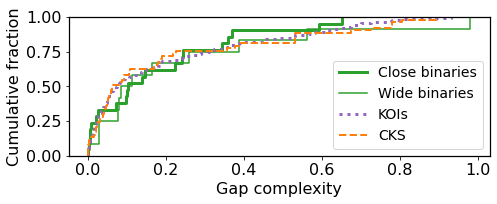

In [60]:
import seaborn as sns

if sullivan:
    cc = '#1f77b4'
else:
    cc = 'C2'

    
fig, ax = plt.subplots(figsize=(7, 3))
sns.ecdfplot(closeb_complexity, ax=ax,
             label='Close binaries', linewidth=3, color=cc)
sns.ecdfplot(wideb_complexity, ax=ax,
             label='Wide binaries', color=cc)

sns.ecdfplot(kois_complexity, ax=ax,
             label='KOIs',     color='C4', linewidth=3, linestyle=':')
sns.ecdfplot(cks_complexity, ax=ax,
             label='CKS',      color='C1', linewidth=2, linestyle='--')
ax.set_xlabel('Gap complexity')
ax.set_ylabel('Cumulative fraction')
ax.legend()

plt.tight_layout()
plt.savefig(filename)




In [55]:
from scipy import stats

ks_statistic, p_value = stats.ks_2samp(cks_complexity, closeb_complexity)
print(f"CKS KS statistic: {ks_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

ks_statistic, p_value = stats.ks_2samp(wideb_complexity, kois_complexity)
print(f"KOIs KS statistic: {ks_statistic:.4f}")
print(f"p-value: {p_value:.4f}")



CKS KS statistic: 0.2213
p-value: 0.3676
KOIs KS statistic: 0.2500
p-value: 0.4164
